In [2]:
%config Completer.use_jedi = False

In [3]:
from pathlib import Path

import numpy as np

from convnwb.io import load_nwbfile

from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.conversions import convert_times_to_rates
from spiketools.spatial.occupancy import compute_bin_counts_assgn, compute_bin_edges, compute_bin_assignment
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.utils import compute_nbins, compute_pos_ranges, convert_2dindices
from spiketools.spatial.target import compute_target_bins
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.data import plot_bar
from spiketools.plts.spatial import plot_heatmap, plot_positions, create_heat_title
from spiketools.plts.utils import make_axes
# from spiketools.plts.annotate import color_pval
from spiketools.utils import set_random_seed
from spiketools.utils.data import compute_range
from spiketools.utils.extract import (get_range, get_value_by_time, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_times)
from spiketools.utils.epoch import epoch_data_by_range, epoch_spikes_by_segment

##################################################
import matplotlib.pyplot as plt
from convnwb.io import get_files, save_json
from pynwb import NWBHDF5IO

from spiketools.utils.base import select_from_list
from spiketools.measures.spikes import compute_firing_rate
from spiketools.plts.utils import make_axes, make_grid, get_grid_subplot, save_figure

In [4]:
import seaborn as sns
sns.set_context('talk')

In [5]:
import sys
sys.path.append('../code')
from models import create_df_target, fit_anova_target
from reports import *

## Settings

In [6]:
# Set random seed, for consistency shuffling
set_random_seed(101)

In [7]:
# Define the base data folder
data_folder = Path('/Users/clairehan/Documents/Data/JacobsLab/WVTH/NWB')

In [8]:
# Define subject information
session = {
    'experiment' : 'THF',
    'subject' : 'wv001',
    'session' : 3
}

In [9]:
BASE_PATH = Path('/Users/clairehan/Documents/Data/JacobsLab/WVTH/')
DATA_PATH = BASE_PATH / 'NWB'

PATHS = {
    'BASE' : BASE_PATH,
    'DATA' : DATA_PATH
}

nwbfiles = get_files(PATHS['DATA'])

In [10]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)
error = nwbfile.trials.error[:]
error

array([12.77042155, 19.03389096, 14.59850223, 31.39324504, 13.38312127,
       54.66060056, 29.50910417, 43.73788657, 39.57787423,  3.22612177,
        3.63622814, 44.45746722, 41.46902835, 53.73914292,  8.85010014,
       11.11199246, 10.42221368, 10.75640853, 22.71083231, 11.15706227,
       18.15696471, 50.05502888, 33.39680329, 11.58630197,  5.93852116,
       27.01795945, 20.0148335 , 23.47486754, 30.30194958, 44.71587078,
       42.2831165 , 35.02711937, 46.89381935,  2.01517632,  0.82439529,
        7.98830465,  5.88241333, 34.89175743, 15.36153381,  4.22376996,
       14.01570125, 20.13369147, 16.08780763, 17.52439915, 22.75302541,
       15.69265052,  9.26154382,  4.86023482, 10.1290374 ,  0.9958909 ,
        5.36792788, 27.0396187 ,  8.93529611,  3.41321116,  9.58685217,
       12.09173679, 19.47290041,  7.44742704,  4.71584394, 11.3708505 ])

### All sessions

In [12]:
nwbfiles_THF = nwbfiles[0:10]
nwbfiles_THO = nwbfiles[10:21]
nwbfiles_THF, nwbfiles_THO

(['THF_wv001_session_0.nwb',
  'THF_wv001_session_2.nwb',
  'THF_wv001_session_3.nwb',
  'THF_wv001_session_4.nwb',
  'THF_wv002_session_0.nwb',
  'THF_wv002_session_1.nwb',
  'THF_wv003_session_0.nwb',
  'THF_wv004_session_0.nwb',
  'THF_wv004_session_1.nwb',
  'THF_wv005_session_0.nwb'],
 ['THO_wv001_session_0.nwb',
  'THO_wv001_session_2.nwb',
  'THO_wv002_session_0.nwb',
  'THO_wv002_session_2.nwb',
  'THO_wv003_session_0.nwb',
  'THO_wv003_session_1.nwb',
  'THO_wv004_session_0.nwb',
  'THO_wv004_session_1.nwb',
  'THO_wv004_session_2.nwb',
  'THO_wv004_session_3.nwb',
  'THO_wv005_session_0.nwb'])

## Significant overlap between tasks

## Group area proportions

### Serial position cell distribution

In [36]:
serial_total_f = (121/643)*100
serial_total_o = (101/609)*100
# serial_total = 198

amg_f = (61/332)*100
amg_o = (74/338)*100
amg_total = ((61+74)/(338+332))*100
ah_f = (29/168)*100
ah_o = (21/121)*100
ah_total = ((29+21)/(168+121))*100
ph_f = (18/143)*100
ph_o = (21/150)*100
ph_total = ((18+21)/(143+150))*100

all_total = (222/1198)*100
chance = 5

In [37]:
THF_dic_area = {
    'Total':'121/643',
    'Amg':'61/332',
    'Anterior Hippo':'29/168',
    'Posterior Hippo':'18/143',
}

THO_dic_area = {
    'Total':'101/609',
    'Amg':'59/338',
    'Anterior Hippo':'21/121',
    'Posterior Hippo':'21/150',
}

THF_dic_percent = {
    'total':serial_total_f,
    'Amg':amg_f,
    'Anterior Hippo':ah_f,
    'Posterior Hippo':ph_f,
}

THO_dic_percent = {
    'total': serial_total_o, 
    'Amg':amg_o,
    'Anterior Hippo':ah_o,
    'Posterior Hippo':ph_o,
}

# total_area = {
#     'Total': '198/1190',
#     'AMG':'106/616',
#     'AH':'55/285',
#     'PH':'37/289'
# }

# total_percent = {
#     'Total':all_total,
#     'AMG':amg_total,
#     'AH':ah_total,
#     'PH':ph_total
# }

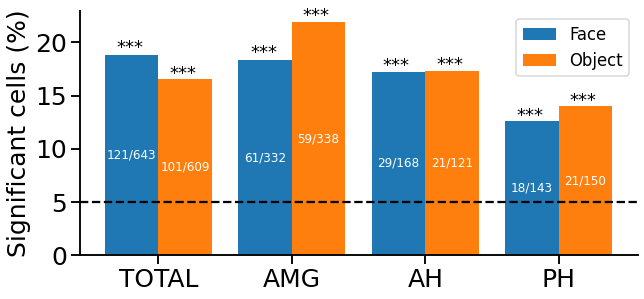

In [38]:
labels = ['TOTAL', 'AMG', 'AH', 'PH']
THF_count = THF_dic_area.values()
THO_count = THO_dic_area.values()

THF_percent = THF_dic_percent.values()
THO_percent = THO_dic_percent.values()

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig = plt.figure(figsize = (10, 4.5))
ax = fig.add_subplot(111)
rects1 = ax.bar(x-width/2, THF_percent, width, label='Face', color='C0')
rects2 = ax.bar(x + width/2, THO_percent, width, label='Object', color='C1')

ax.set(ylabel='Significant cells (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels) 
ax.legend()

ax.bar_label(rects1, THF_count, label_type='center', fontsize=12, color='white')
ax.bar_label(rects2, THO_count, label_type='center', fontsize=12, color='white')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# horizontal line indicating the threshold
plt.axhline(y=chance, color='k', linestyle='--')

ax.text(-0.31, 19, '***')
ax.text(0.08, 16.6, '***')
ax.text(0.69, 18.5, '***')
ax.text(1.08, 22, '***')
ax.text(1.68, 17.3, '***')
ax.text(2.08, 17.4, '***')
ax.text(2.68, 12.6, '***')
ax.text(3.08, 14, '***')

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel('Significant cells (%)', fontsize=25)

save_figure('serial_population' + '.svg', '/Users/clairehan/Desktop', close=False, bbox_inches='tight')

In [52]:
from scipy import stats
stats.binom_test(18, n=143, p=0.05, alternative='greater') 

0.0003021079545420941

In [70]:
stats.binom_test(18, n=143, p=0.05, alternative='greater') 

0.0003021079545420941

### Place cell distribution

In [47]:
place_total_f = (28/602)*100
place_total_o = (36/516)*100
place_total = 64

amg_f = (12/332)*100
amg_o = (16/284)*100
# amg_total = ((69+37)/(332+284))*100
ah_f = (8/168)*100
ah_o = (7/117)*100
# ah_total = ((30+25)/(168+117))*100
ph_f = (8/146)*100
ph_o = (13/143)*100
# ph_total = ((19+18)/(146+143))*100

all_total = (64/1190)*100
chance = 5

In [104]:
THF_dic_area = {
    'Total': '28/602',
    'Amg':'12/332',
    'Anterior Hippo':'8/168',
    'Posterior Hippo':'8/146',
}

THO_dic_area = {
    'Total': '36/516',
    'Amg':'16/284',
    'Anterior Hippo':'7/117',
    'Posterior Hippo':'13/143',
}

THF_dic_percent = {
    'Total':place_total_f,
    'Amg':amg_f,
    'Anterior Hippo':ah_f,
    'Posterior Hippo':ph_f,
}

THO_dic_percent = {
    'Total':place_total_o,
    'Amg':amg_o,
    'Anterior Hippo':ah_o,
    'Posterior Hippo':ph_o,
}

NameError: name 'place_total_f' is not defined

In [ ]:
labels = ['TOTAL', 'AMG', 'AH', 'PH']
THF_count = THF_dic_area.values()
THO_count = THO_dic_area.values()

THF_percent = THF_dic_percent.values()
THO_percent = THO_dic_percent.values()

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig = plt.figure(figsize = (7, 5))
ax = fig.add_subplot(111)
rects1 = ax.bar(x - width/2, THF_percent, width, label='THF', color='#1d2e58')
rects2 = ax.bar(x + width/2, THO_percent, width, label='THO', color='darkred')

ax.set(ylabel='Significant cells (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels) 
ax.legend()

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.bar_label(rects1, THF_count, label_type='center', fontsize=10, color='white')
ax.bar_label(rects2, THO_count, label_type='center', fontsize=10, color='white')

# horizontal line indicating the threshold
plt.axhline(y=chance, color='black', linestyle='--')
ax.set(ylim=[0,10])
# ax.text(-0.28, 4.5, '***')
ax.text(0.14, 7, '*')
# ax.text(0.72, 20.6, '***')
# ax.text(1.06, 13, '***')
# ax.text(1.73, 17.77, '***')
# ax.text(2.07, 21.3, '***')
# ax.text(2.72, 12.95, '***')
ax.text(3.15, 9.1, '*')

save_figure('place_population' + '.eps', '../figures', close=False, bbox_inches='tight')

In [138]:
stats.binom_test(13, n=143, p=0.05, alternative='greater') 

0.02761734035189282

### Spatial target cell distribution

In [11]:
target_total_f = (43/643)*100
target_total_o = (43/609)*100
amg_f = (24/332)*100
amg_o = (29/338)*100
ah_f = (12/168)*100
ah_o = (6/121)*100
ph_f = (7/143)*100
ph_o = (8/150)*100

chance = 5

In [12]:
THF_dic_area = {
    'total':'43/643',
    'Amg':'24/332',
    'Anterior Hippo':'12/168',
    'Posterior Hippo':'7/143',
}

THO_dic_area = {
    'total':'43/609',
    'Amg':'29/338',
    'Anterior Hippo':'6/121',
    'Posterior Hippo':'8/150',
}

THF_dic_percent = {
    'total':target_total_f,
    'Amg':amg_f,
    'Anterior Hippo':ah_f,
    'Posterior Hippo':ph_f,
}

THO_dic_percent = {
    'total':target_total_o,
    'Amg':amg_o,
    'Anterior Hippo':ah_o,
    'Posterior Hippo':ph_o,
}

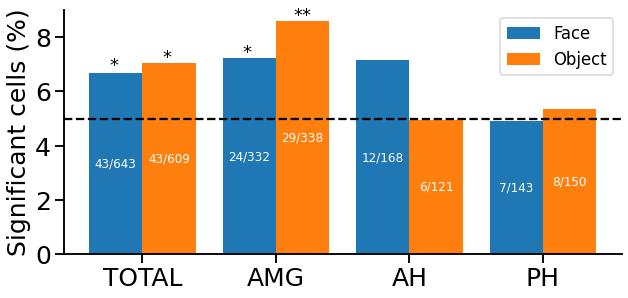

In [15]:
labels = ['TOTAL','AMG', 'AH', 'PH']
THF_count = THF_dic_area.values()
THO_count = THO_dic_area.values()

THF_percent = THF_dic_percent.values()
THO_percent = THO_dic_percent.values()

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig = plt.figure(figsize = (10, 4.5))
ax = fig.add_subplot(111)
rects1 = ax.bar(x - width/2, THF_percent, width, label='Face', color='C0')
rects2 = ax.bar(x + width/2, THO_percent, width, label='Object', color='C1')

ax.set(ylabel='Significant cells (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels) 
ax.legend()

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.bar_label(rects1, THF_count, label_type='center', fontsize=12, color='white')
ax.bar_label(rects2, THO_count, label_type='center', fontsize=12, color='white')

# horizontal line indicating the threshold
plt.axhline(y=chance, color='k', linestyle='--')
ax.text(-0.25, 6.75, '*')
ax.text(0.15, 7.05, '*')
ax.text(0.75, 7.25, '*')
ax.text(1.13, 8.6, '**')

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel('Significant cells (%)', fontsize=25)


save_figure('target_population' + '.svg', '/Users/clairehan/Desktop', close=False, bbox_inches='tight')

In [75]:
stats.binom_test(12, n=168, p=0.05, alternative='greater') 

0.13737173813245504

In [16]:
# full_total_f = 108
# full_total_o = 57
full_total_f = (108/643)*100
full_total_o = (63/609)*100
amg_f = (55/332)*100
amg_o = (37/338)*100
ah_f = (29/168)*100
ah_o = (10/121)*100
ph_f = (24/143)*100
ph_o = (16/150)*100

chance = 5

In [17]:
THF_dic_area = {
    'total': '108/643',
    'Amg':'55/332',
    'Anterior Hippo':'29/168',
    'Posterior Hippo':'24/143',
}

THO_dic_area = {
    'total':'63/609',
    'Amg':'37/338',
    'Anterior Hippo':'10/121',
    'Posterior Hippo':'16/150',
}

THF_dic_percent = {
    'total':full_total_f,
    'Amg':amg_f,
    'Anterior Hippo':ah_f,
    'Posterior Hippo':ph_f,
}

THO_dic_percent = {
    'total':full_total_o,
    'Amg':amg_o,
    'Anterior Hippo':ah_o,
    'Posterior Hippo':ph_o,
}

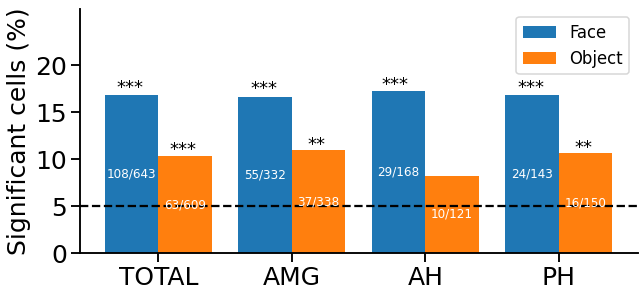

In [27]:
labels = ['TOTAL','AMG', 'AH', 'PH']
THF_count = THF_dic_area.values()
THO_count = THO_dic_area.values()

THF_percent = THF_dic_percent.values()
THO_percent = THO_dic_percent.values()

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig = plt.figure(figsize = (10, 4.5))
ax = fig.add_subplot(111)
rects1 = ax.bar(x - width/2, THF_percent, width, label='Face', color='C0')
rects2 = ax.bar(x + width/2, THO_percent, width, label='Object', color='C1')

ax.set(ylabel='Significant cells (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels) 
ax.legend(loc='best')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.bar_label(rects1, THF_count, label_type='center', fontsize=12, color='white')
ax.bar_label(rects2, THO_count, label_type='center', fontsize=12, color='white')

# horizontal line indicating the threshold
plt.axhline(y=chance, color='k', linestyle='--')
ax.set(ylim=(0,26),yticks=[0,5,10,15,20])
ax.text(-0.31, 17, '***')
ax.text(0.08, 10.5, '***')
ax.text(0.69, 16.9, '***')
ax.text(1.12, 11, '**')
ax.text(1.67, 17.4, '***')

ax.text(2.69, 17, '***')
ax.text(3.12, 10.7, '**')

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel('Significant cells (%)', fontsize=25)


save_figure('chest_population' + '.svg', '/Users/clairehan/Desktop', close=False, bbox_inches='tight')

In [39]:
# full_total_f = 108
# full_total_o = 57
baseline_total_f = (106/643)*100
baseline_total_o = (72/609)*100
amg_f = (48/332)*100
amg_o = (32/338)*100
ah_f = (49/168)*100
ah_o = (22/121)*100
ph_f = (9/143)*100
ph_o = (18/150)*100

chance = 5

In [40]:
THF_dic_area = {
    'total': '106/643',
    'Amg':'48/332',
    'Anterior Hippo':'49/168',
    'Posterior Hippo':'9/143',
}

THO_dic_area = {
    'total':'72/609',
    'Amg':'32/338',
    'Anterior Hippo':'22/121',
    'Posterior Hippo':'18/150',
}

THF_dic_percent = {
    'total':baseline_total_f,
    'Amg':amg_f,
    'Anterior Hippo':ah_f,
    'Posterior Hippo':ph_f,
}

THO_dic_percent = {
    'total':baseline_total_o,
    'Amg':amg_o,
    'Anterior Hippo':ah_o,
    'Posterior Hippo':ph_o,
}

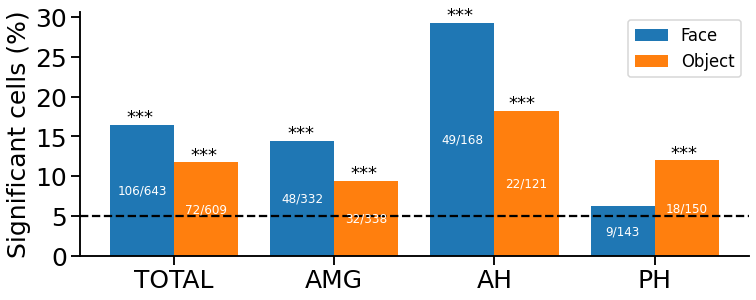

In [42]:
labels = ['TOTAL','AMG', 'AH', 'PH']
THF_count = THF_dic_area.values()
THO_count = THO_dic_area.values()

THF_percent = THF_dic_percent.values()
THO_percent = THO_dic_percent.values()

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig = plt.figure(figsize = (12, 4.5))
ax = fig.add_subplot(111)
rects1 = ax.bar(x - width/2, THF_percent, width, label='Face', color='C0')
rects2 = ax.bar(x + width/2, THO_percent, width, label='Object', color='C1')

ax.set(ylabel='Significant cells (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels) 
ax.legend(loc='best')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.bar_label(rects1, THF_count, label_type='center', fontsize=12, color='white')
ax.bar_label(rects2, THO_count, label_type='center', fontsize=12, color='white')

# horizontal line indicating the threshold
plt.axhline(y=chance, color='k', linestyle='--')
# ax.set(ylim=[0,26], yticks=[0,5,10,15,20, 25])
ax.text(-0.30, 16.8, '***')
ax.text(0.10, 12, '***')
ax.text(0.71, 14.8, '***')
ax.text(1.1, 9.8, '***')
ax.text(1.7, 29.5, '***')
ax.text(2.09, 18.5, '***')
# ax.text(2.68, 30, '***')
ax.text(3.1, 12.3, '***')

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel('Significant cells (%)', fontsize=25)

save_figure('baseline_population' + '.svg', '/Users/clairehan/Desktop', close=False, bbox_inches='tight')

In [9]:
# full_total_f = 108
# full_total_o = 57
ID_total_f = (53/643)*100
ID_total_o = (88/609)*100
amg_f = (21/332)*100
amg_o = (56/338)*100
ah_f = (27/168)*100
ah_o = (16/121)*100
ph_f = (5/143)*100
ph_o = (16/150)*100

chance = 5

In [10]:
THF_dic_area = {
    'total': '53/643',
    'Amg':'21/332',
    'Anterior Hippo':'27/168',
    'Posterior Hippo':'5/143',
}

THO_dic_area = {
    'total':'88/609',
    'Amg':'56/338',
    'Anterior Hippo':'16/121',
    'Posterior Hippo':'16/150',
}

THF_dic_percent = {
    'total':ID_total_f,
    'Amg':amg_f,
    'Anterior Hippo':ah_f,
    'Posterior Hippo':ph_f,
}

THO_dic_percent = {
    'total':ID_total_o,
    'Amg':amg_o,
    'Anterior Hippo':ah_o,
    'Posterior Hippo':ph_o,
}

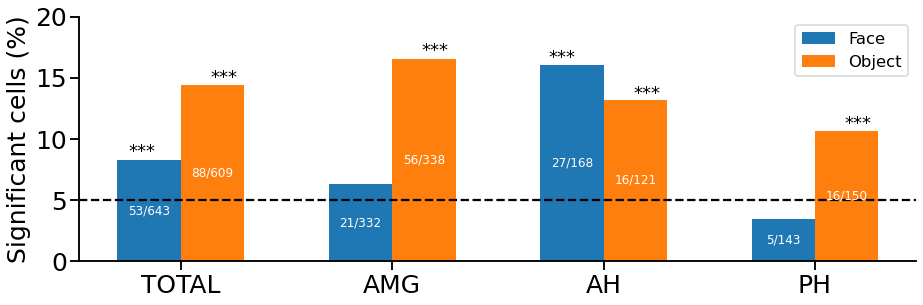

In [29]:
labels = ['TOTAL','AMG', 'AH', 'PH']
THF_count = THF_dic_area.values()
THO_count = THO_dic_area.values()

THF_percent = THF_dic_percent.values()
THO_percent = THO_dic_percent.values()

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig = plt.figure(figsize = (15, 4.5))
ax = fig.add_subplot(111)
rects1 = ax.bar(x - width/2, THF_percent, width, label='Face', color='C0')
rects2 = ax.bar(x + width/2, THO_percent, width, label='Object', color='C1')

ax.set(ylabel='Significant cells (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels) 
ax.legend(loc='best')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.bar_label(rects1, THF_count, label_type='center', fontsize=12, color='white')
ax.bar_label(rects2, THO_count, label_type='center', fontsize=12, color='white')

# horizontal line indicating the threshold
plt.axhline(y=chance, color='k', linestyle='--')
ax.set(ylim=[0,20], yticks=[0,5,10,15,20])
ax.text(-0.25, 8.5, '***')
ax.text(0.14, 14.6, '***')
ax.text(1.14, 16.8, '***')
ax.text(1.74, 16.2, '***')
ax.text(2.14, 13.3, '***')
ax.text(3.14, 10.8, '***')

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel('Significant cells (%)', fontsize=25)

save_figure('ID_population' + '.svg', '/Users/clairehan/Desktop', close=False, bbox_inches='tight')

In [190]:
stats.binom_test(16, n=150, p=0.05, alternative='greater') 

0.0036031440281856096

## Cell type overlap

#### one cell identity only

In [ ]:
########################THF
# chest_only = (67/108)*100
# place_only = (19/28)*100
# target_only = (57/89)*100
# serial_only = (77/118)*100

# one_id_count = {
#     'full chest only': '67/108',
#     'place only': '19/28',
#     'target only': '57/89',
#     'serial position only': '77/118'
# }
# one_id_percent = {
#     'full chest only': chest_only,
#     'place only': place_only,
#     'target only': target_only,
#     'serial position only': serial_only
# }

#########################THO
chest_only = (37/57)*100
place_only = (25/36)*100
target_only = (35/65)*100
serial_only = (43/80)*100

one_id_count = {
    'full chest only': '37/57',
    'place only': '25/36',
    'target only': '35/65',
    'serial position only': '43/80'
}
one_id_percent = {
    'full chest only': chest_only,
    'place only': place_only,
    'target only': target_only,
    'serial position only': serial_only
}

In [ ]:
labels = ['full chest', 'place', 'target', 'serial position']
one_count = one_id_count.values()
one_percent = one_id_percent.values()

x = np.arange(len(labels))  # the label locations
width=0.7
chance=5

fig = plt.figure(figsize = (7, 5))
ax = fig.add_subplot(111)
rects1 = ax.bar(x, one_percent, width, color='silver')
ax.bar_label(rects1, one_count, label_type='center', color='white', fontsize=14)

ax.set(ylabel='Significant cells (%)', title='THO - Single identity cells')
ax.set_xticks(x)
ax.set_xticklabels(labels) 

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# horizontal line indicating the threshold
# plt.axhline(y=chance, color='k', linestyle='--')  

#### two cell identities only

In [ ]:
two_id_count = {
    'full chest & place': '1/86',
    'full chest & target': '12/124',
    'full chest & serial position': '20/144',
    'place & target': '3/76',
    'place & serial position': '4/96',
    'target & serial position': '10/134'
}

two_id_percent = {
    'full chest & place': (1/86)*100,
    'full chest & target': (12/124)*100,
    'full chest & serial position': (20/144)*100,
    'place & target': (3/76)*100,
    'place & serial position': (4/96)*100,
    'target & serial position': (10/134)*100
}

#############################THO
# two_id_count = {
#     'full chest & place': '3/62',
#     'full chest & target': '5/72',
#     'full chest & serial position': '9/80',
#     'place & target': '1/60',
#     'place & serial position': '4/68',
#     'target & serial position': '21/78'
# }

# two_id_percent = {
#     'full chest & place': (3/62)*100,
#     'full chest & target': (5/72)*100,
#     'full chest & serial position': (9/80)*100,
#     'place & target': (1/60)*100,
#     'place & serial position': (4/68)*100,
#     'target & serial position': (21/78)*100
# }

In [ ]:
labels = ['chest+place', 'chest+target', 'chest+serial', 'place+target', 'place+serial', 'target+serial']
two_count = two_id_count.values()
two_percent = two_id_percent.values()

x = np.arange(len(labels))  # the label locations
width=0.7
chance=5

fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(111)
rects1 = ax.bar(x, two_percent, width, color='silver')
ax.bar_label(rects1, two_count, label_type='center', color='white', fontsize=14)

ax.set(ylabel='Significant cells (%)', title='THF - Duo identity cells')
ax.set_xticks(x)
ax.set_xticklabels(labels) 

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.axhline(y=chance, color='k', linestyle='--')  

#### three cell identites only 

In [ ]:
three_id_count = {
    'full chest & place & target': '1/97',
    'full chest & place & serial position': '1/105',
    'full chest & target & serial position': '1/115',
    'place & target & serial position': '0/103',
    'all type overlap': '0/140'
}

three_id_percent = {
    'full chest & place & target': (1/97)*100,
    'full chest & place & serial position': (1/105)*100,
    'full chest & target & serial position': (1/115)*100,
    'place & target & serial position': 0,
    'all type overlap': 0
}



In [ ]:
labels = ['chest+place+target', 'chest+place+serial', 'chest+target+serial', 'place+target+serial', 'all 4 types']
three_count = three_id_count.values()
three_percent = three_id_percent.values()

x = np.arange(len(labels))  # the label locations
width=0.7
chance=5

fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(111)
rects1 = ax.bar(x, three_percent, width, color='silver')
ax.bar_label(rects1, three_count, label_type='center', color='white', fontsize=14)

ax.set(ylabel='Significant cells (%)', title='THO - All identity cells')
ax.set_xticks(x)
ax.set_xticklabels(labels) 

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# plt.axhline(y=chance, color='k', linestyle='--')  

## THF significant cell distribution across subjects/sessions

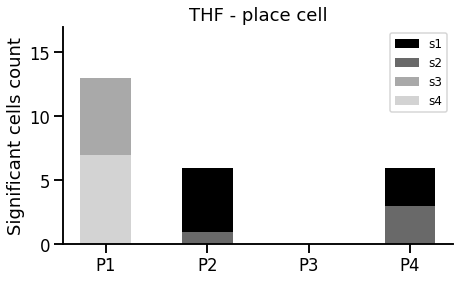

In [20]:
labels = ['P1', 'P2', 'P3', 'P4']
s1_counts = [2, 5, 0, 3]
s2_counts = [1, 1, 0, 3]
s3_counts = [6,0,0,0]
s4_counts = [7,0,0,0]
width = 0.5       # the width of the bars: can also be len(x) sequence

fig = plt.figure(figsize = (7, 4))
ax = fig.add_subplot(111)

ax.bar(labels, s1_counts, width, label='s1', color='black', bottom=s2_counts)
ax.bar(labels, s2_counts, width, label='s2', color='dimgray', bottom=s3_counts) #bottom=men_means
ax.bar(labels, s3_counts, width, label='s3', color='darkgray', bottom=s4_counts)
ax.bar(labels, s4_counts, width, label='s4', color='lightgray')
ax.set(ylabel='Significant cells count', title='THF - place cell')
ax.legend(loc=0, prop={'size': 12})
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylim([0,17])
plt.show()

In [ ]:
# create data
x = np.arange(4)
labels = ['P1', 'P2', 'P3', 'P4']
s1 = [6, 1, 1, 18]
s2 = [0, 0, 3, 6]
s3 = [9, 1, 0, 5]
s4 = [0, 0, 0, 7]
width = 0.2

fig = plt.figure(figsize = (7, 4))
ax = fig.add_subplot(111)
  
# plot data in grouped manner of bar type
ax.bar(x-0.3, s1, width, label='s1',color='black')
ax.bar(x-0.1, s2, width, label='s2',color='dimgray')
ax.bar(x+0.1, s3, width, label='s3',color='darkgray')
ax.bar(x+0.3, s3, width, label='s4',color='lightgray')
plt.xticks(x, ['P1', 'P2', 'P3', 'P4'])
ax.set(ylabel='Significant cells count', title='THO - full chest cell')

ax.legend(loc=0, prop={'size': 12})
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.show()

In [117]:
import scipy.io
import pandas as pd
mat = scipy.io.loadmat('/Users/clairehan/Desktop/ID_object.mat')

In [131]:
mat['ID_neuron'][0]

array([  1,  85, 178, 185, 276, 308, 324, 376, 398, 399, 428, 437, 446,
       497, 504, 506, 530, 557, 594, 600, 647, 651, 670, 681, 687, 689,
       734, 756, 765, 767, 872,  51,  64,  97, 133, 139, 150, 157, 161,
       165, 177, 201, 236, 283, 374, 393, 400, 403, 433, 445, 455, 477,
       483, 484, 491, 498, 512, 531, 532, 534, 546, 560, 568, 584, 585,
       586, 601, 602, 613, 623, 627, 628, 652, 656, 661, 668, 688, 702,
       705, 708, 769, 770, 772, 841, 844, 850, 852, 888], dtype=uint16)

In [119]:
df_THO = pd.read_csv("/Users/clairehan/Desktop/THresults-nov3/THO_all_results_nov3.csv")

In [136]:
# for ind 
np.where([df_THO.wvID.values == mat['ID_neuron'][0][ind] for ind in range(88)])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87]),
 array([  0,  63, 132, 136, 187, 209, 222, 255, 266, 267, 282, 288, 292,
        346, 348, 350, 364, 385, 329, 334, 424, 425, 439, 448, 453, 455,
        490, 503, 510, 512, 590,  39,  48,  68,  99, 105, 112, 117, 120,
        122, 131, 149, 160, 193, 253, 264, 268, 269, 285, 291, 298, 308,
        313, 314, 343, 347, 355, 365, 366, 368, 376, 387, 391, 322, 323,
        324, 335, 336, 398, 407, 409, 410, 426, 428, 432, 437, 454, 465,
        468, 470, 513, 514, 516, 567, 569, 574, 576, 601]))